In [52]:
# Execute if necessary
# %%capture
#!pip install numpy seaborn matplotlib pandas statsmodels

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
from statsmodels.graphics.tsaplots import plot_acf

# Práctica 3: Prepocesamiento de Series de Tiempo

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones. Cada función está marcada por &#x1F625;,  &#x1F643; o &#x1F921;. Las marcas indican:

- &#x1F625;: Indican una entrega que debe ser hecha dentro de la misma sesión de la asignación. 
- &#x1F643;: Indican una entrega que puede ser hecha hasta la siguiente sesión.
- &#x1F921;: Debe mostrar un avance en la misma sesión, pero la entrega puede ser hecha en la siguiente.

Aquellas entregas parciales que no sean hechas el día de la asignación ya no serán válidas para las entregas totales, sin embargo, las entregas totales seguirán siendo válidas.

En esta sección se incluye una serie de tiempo real. El dataset importado incluye cuatro series de tiempo de la ciudad de Delhi, India, desde el 1 de enero de 2013 al 1 de enero de 2017 en muestreos diarios. Las series de tiempo incluidas son:

- __meantemp__: Temperatura promedio del día.
- __humidity__: Humedad promedio del día.
- __wind_speed__: Velocidad promedio del viento en el día.
- __meanpressure__: Presión promedio del día.

Este conjunto de datos no contiene datos nulos, por lo que no es necesario realizar una imputación dedatos.

In [54]:
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["date"] = pd.to_datetime(df["date"])
df.head(3)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.5,0.000000,1015.666667
1,2013-01-02,7.400000,92.0,2.980000,1017.800000
2,2013-01-03,7.166667,87.0,4.633333,1018.666667


## Asignación 1 &#x1F625;

La serie de tiempo __meanpressure__ contiene outliers. Analice la serie de tiempo y con base en su análisis, sustituya los outliers por valores válidos.

<AxesSubplot:xlabel='meanpressure', ylabel='Count'>

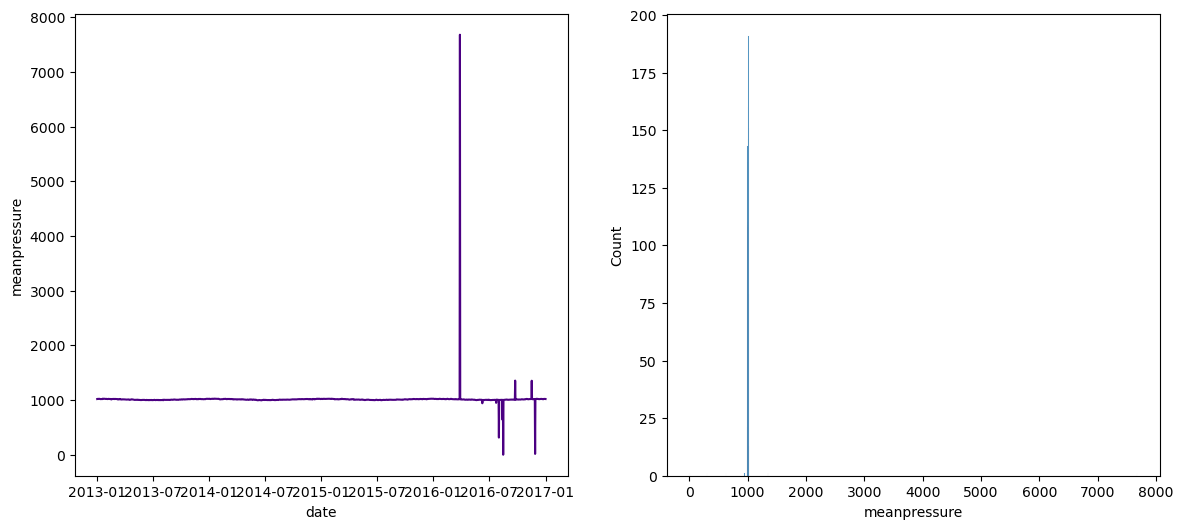

In [55]:
# Graficamos la serie del tiempo para ver si se ven los outliers

fig, axs = plt.subplots(ncols=2, nrows= 1, figsize=(14, 6))

sns.lineplot(data=df, x="date", y="meanpressure", color = "indigo", ax = axs[0])
sns.histplot(data = df, x="meanpressure" ,ax = axs[1])

In [56]:
# Dada la naturaleza de la presión atmosférica es díficil que pase de
# abajo de los 950 y arriba de los 1100 kpa
outliers = df.query("meanpressure > 1100 or meanpressure < 950").index

print("Los valores anormales están en los registros: ", outliers.values)

# Reemplazamos los outliers con valores que tuvo un ciclo anterior a él
# (cada ciclo es un año con 365 días)
for i in outliers:
    df.loc[i, 'meanpressure'] = df.at[i - 365, "meanpressure"]

Los valores anormales están en los registros:  [1182 1255 1300 1309 1321 1323 1362 1416 1427]


<AxesSubplot:xlabel='meanpressure', ylabel='Count'>

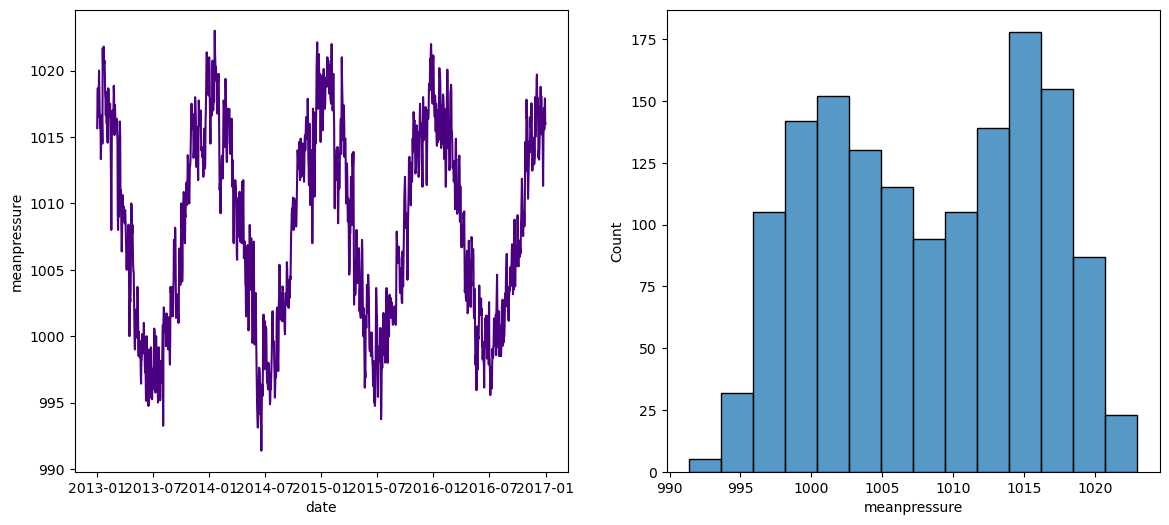

In [57]:
# Graficamos la serie de tiempo con los valores reemplazados
fig, axs = plt.subplots(ncols=2, nrows= 1, figsize=(14, 6))

sns.lineplot(data=df, x="date", y="meanpressure", color = "indigo", ax = axs[0])
sns.histplot(data = df, x="meanpressure" ,ax = axs[1])

## Asignación 2 &#x1F625;

Normalice todas las series de tiempo para que tengan media cero y varianza 1.  Imprima la descripción del dataframe para validar.

In [58]:
def normalize_dataframe(data):
    data_scaled = data
    for i in data.columns:
        if df[i].dtype == 'int64' or df[i].dtype == 'float64':
            media = np.sum(data[i])/len(data[i])
            sd = np.std(data[i])
            data_scaled[i] = (data[i] - media)/sd

    return data_scaled

In [59]:
df_scaled = normalize_dataframe(df)
df_scaled.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1.462000e+03,1.462000e+03,1.462000e+03,1.462000e+03
mean,-1.458022e-17,1.968330e-16,-1.944029e-16,7.946220e-15
std,1.000342e+00,1.000342e+00,1.000342e+00,1.000342e+00
min,-2.654044e+00,-2.824109e+00,-1.491699e+00,-2.270397e+00
25%,-9.037230e-01,-6.201833e-01,-7.296443e-01,-8.915830e-01
50%,3.020541e-01,1.105528e-01,-1.273107e-01,4.177210e-02
75%,7.909894e-01,6.828386e-01,5.342114e-01,8.970918e-01
max,1.799551e+00,2.340044e+00,7.766988e+00,1.983748e+00


## Asignación 3 &#x1F625;

Entrene una regresión lineal para predecir el valor de __meantemp__ utilizando las series de tiempo __humidity__, __wind_speed__ y __meanpressure__. Use la función _numpy.linalg.lstsq_ para esto. Una vez entrenada la regresión, grafique la serie de tiempo __meantemp__ junto con la serie de tiempo de las predicciones del modelo.

In [60]:
meantemp = df_scaled["meantemp"].values
A = np.matrix([
    df_scaled["humidity"].values, 
    df_scaled["wind_speed"].values, 
    df_scaled["meanpressure"].values])

w = np.linalg.lstsq(A.T, meantemp, rcond=None)[0]

df_scaled["pred_meantemp"] = np.matmul(w, A).T

<AxesSubplot:>

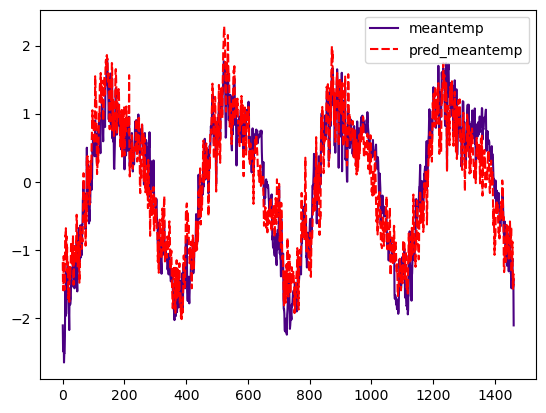

In [61]:
sns.lineplot(data=df[['meantemp', 'pred_meantemp']], palette=['indigo', 'red'])

## Asignación 4 &#x1F643;

La serie de tiempo __meantemp__ presenta ciclos por temporadas y una ligera tendencia creciente. Entrene una regresión lineal donde las variables independientes estén en función del tiempo que permita replicar estas tendencias. En una sola gráfica imprima la serie de tiempo __meantemp__, la gráfica de la tendencia (predicciones del modelo) y la gráfica sin tendencia, es decir, la resta de la serie de tiempo __meantemp__ y las predicciones del modelo (residuales).

Nota: Utilice una frecuencia fija de $1/365$ para replicar los ciclos.

In [62]:
time = np.arange(len(meantemp))
bias = np.ones(len(meantemp))
frequency = 1/365
phase = np.pi/2
sen = np.sin((2 * np.pi * frequency * time) + phase) 
cos = np.cos((2 * np.pi * frequency * time) + phase)

# Define characteristics and target
x = np.column_stack((bias, time, sen, cos))

# Apply linear regression
w, residuals, rank, s = np.linalg.lstsq(x, meantemp, rcond=None)

<AxesSubplot:>

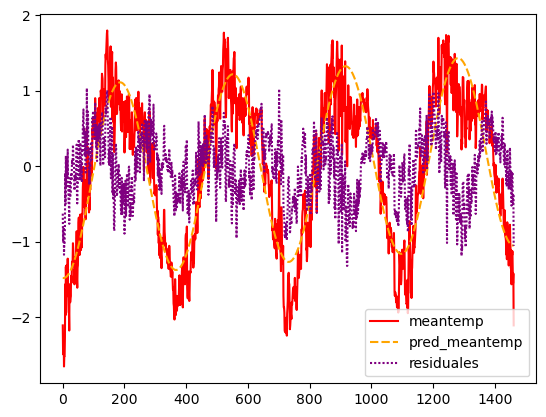

In [63]:
df_scaled["pred_meantemp"] = np.matmul(w, x.T).T

df_scaled["residuales"] = meantemp - df_scaled["pred_meantemp"]

sns.lineplot(data=df[['meantemp', 'pred_meantemp', 'residuales']], palette=['red', 'orange', 'purple'])

## Asignación 5 &#x1F643;

Elimine las tendencias de la serie de tiempo __meantemp__ utilizando diferencias de primero orden. Debe realizar dos diferencias, una para eliminar la tendencia creciente y otra para eliminar los ciclos por temporadas. Grafique la serie de tiempo de __meantemp__ junto con la serie de tiempo estacionaria.

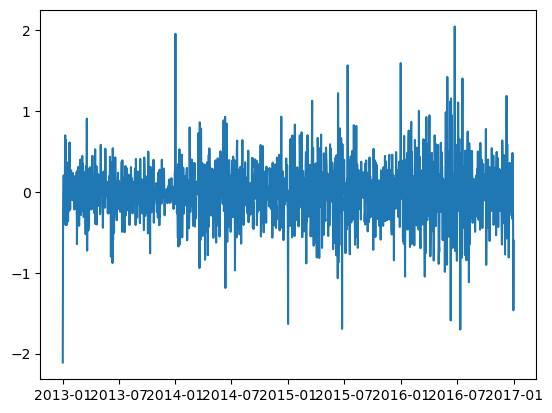

In [64]:
dif1 = np.zeros(len(meantemp))
for t, i in enumerate(meantemp):
    if t != 0:
        dif1[t] = meantemp[t] - meantemp[t-1]
    else:
        dif1[t] = meantemp[t]
    if t >= 365:
        dif1[t] = dif1[t] - dif1[t-365]
        
plt.plot(df_scaled["date"], dif1)

## Asignación 6 &#x1F643;

Grafique el correlograma de la serie de tiempo __meantemp__ y el correlograma de __meantemp__ diferenciada (estacionaria). Utilice la función _plot_acf_ para graficar el correlograma.

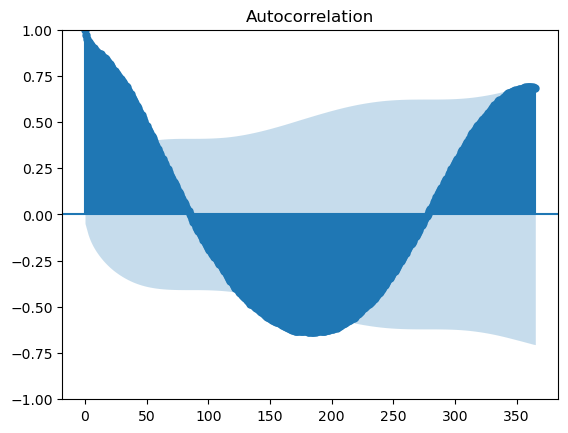

In [65]:
_ = plot_acf(meantemp, lags=365)

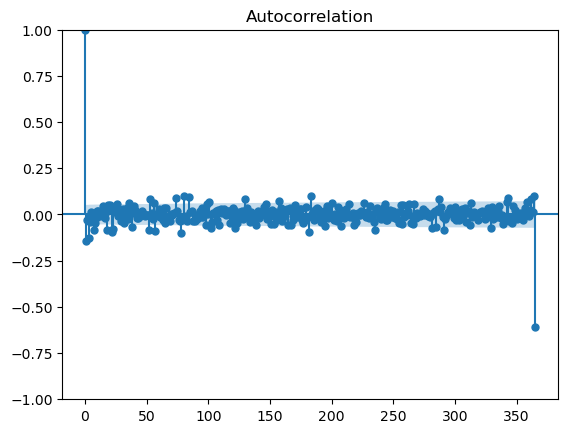

In [66]:
_ = plot_acf(dif1, lags=365)